# Подключение библиотек

In [192]:
#!g1.2
import torch

import torch.nn as nn

import torchvision

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import tarfile

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm, trange

import time

import os

# Загрузка данных

In [193]:
#!g1.2
dir_name = os.getcwd()
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [194]:
#!g1.2
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 100, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 100, shuffle = False
)

# Объявление моделей

In [195]:
#!g1.2
modelsList = [
    (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.DEFAULT, "ResNet18"),
    (torchvision.models.resnet152, torchvision.models.ResNet152_Weights.DEFAULT, "ResNet152"),
    (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.DEFAULT, "EfficientNet_B0"),
    (torchvision.models.efficientnet_b7, torchvision.models.EfficientNet_B7_Weights.DEFAULT, "EfficientNet_B7")
]
for model, weights, _ in modelsList:
    model(weights = weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 18.8MB/s]
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:06<00:00, 39.0MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 17.7MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:13<00:00, 19.7MB/s] 


cuda


In [196]:
#!g1.2
def get_accuracy(data_loader, model, desc):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: #tqdm(data_loader, leave=False, desc = desc):
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def TrainModel(model, trainDataloader, testDataloader, optimizer, lossFn, numEpochs):
    trainScore, testScore = [0], [0]
    timeSpend = []
    pBar = trange(numEpochs, leave=False)
    for epoch in pBar:
        timeStart = time.time()
        pBar.set_postfix({'Last train score': round(float(trainScore[-1]), 5), 'test score' : round(float(testScore[-1]), 5)})
        for (images, labels) in train_data_loader: #tqdm(train_data_loader, leave=False, desc = 'training'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = lossFn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        timeSpend.append(time.time() - timeStart)

        trainScore.append(get_accuracy(trainDataloader, model, 'Calculating train score'))
        testScore.append(get_accuracy(testDataloader, model, 'Calculating test score'))
    return (timeSpend, trainScore, testScore)

# Обучение моделей

In [198]:
#!g1.2
learningRate = 0.05
numEpochs = 30
results = []

pBar = tqdm(modelsList, leave=False)
for modelName, modelWeights, modelLabel in pBar:
    pBar.set_description(modelLabel)
    model = modelName(weights = modelWeights).to(device)
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Linear(model.fc.in_features, 10).to(device)
    else:
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 10).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    res = TrainModel(model=model,
                     trainDataloader=train_data_loader,
                     testDataloader=test_data_loader,
                     optimizer=optimizer,
                     lossFn=loss_fn,
                     numEpochs=numEpochs)
    results.append((modelLabel + " full", res))
    
    model = modelName(weights = modelWeights).to(device)
    for param in model.parameters():
        param.requires_grad = False
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Linear(model.fc.in_features, 10).to(device)
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=learningRate)
    else:
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 10).to(device)
        optimizer = torch.optim.SGD(model.classifier[-1].parameters(), lr=learningRate)

    loss_fn = nn.CrossEntropyLoss()
    res = TrainModel(model=model,
                     trainDataloader=train_data_loader,
                     testDataloader=test_data_loader,
                     optimizer=optimizer,
                     lossFn=loss_fn,
                     numEpochs=numEpochs)
    results.append((modelLabel + " last layer", res))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

# Результаты

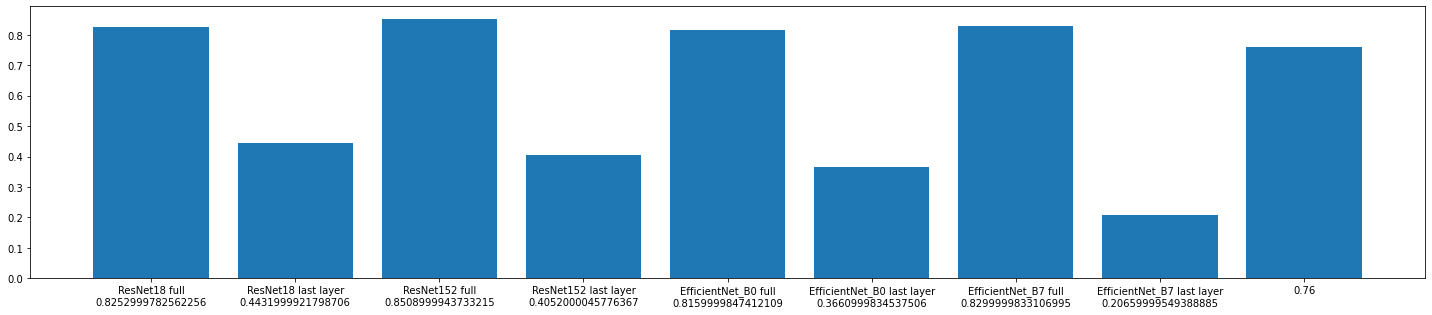

In [205]:
#!g1.2
fig, ax = plt.subplots(1, 1, figsize = (25, 5))
oldRes = 0.76
ax.bar([i for i in range(len(results) + 1)], 
       [float(max(val[1][2])) for val in results] + [oldRes],
       tick_label = [f'{val[0]}\n{float(max(val[1][2]))}' for val in results] + [oldRes])
plt.show()

В результате лучшую точность показала модель ResNet152 при условии полного обучения. Тончость оказалась равна 85%.
Также хочется отметить что все модели, у которых обучался только последний слой показали гораздо хучший результат по сравнению с полностью обученными версиями.